# Anomaly Detection

- The project is applied in claims in Motor LoB to detect possible "fraud" or anomalies.

## Set-up 

### General libraries

In [1]:
import os
import sys
import datetime
import pandas as pd
from pandas import DataFrame
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from os.path import join

pd.set_option("display.max_columns", None)
pd.options.display.float_format = '{:,.4f}'.format### General libraries

### Logging

In [2]:
import logging

logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

### Load enviroment variables

In [3]:
from dotenv import load_dotenv
load_dotenv('.env')

code_root = os.environ['CODE_ROOT']
cfg_path = os.environ['CFG_PATH']
data_root = os.environ['DATA_ROOT']

sys.path.insert(0, code_root)

KeyError: 'CODE_ROOT'

### Specific libraries

In [4]:
from src.model.functions import get_pipeline, get_train_model, save_pipeline
from src.model_interpretability.functions import Interpretability

from src.feature_selection.functions import get_features
from src.prediction.functions import get_scores_if, get_output_data, min_max_normalize_column
from src.utils import get_data_dict, get_config_dict
from src.stability.functions import stability_measure, create_temp_result_df, create_temp_stab_df, calculate_metrics, get_last_weeks_mondays, separate_datasets
from sklearn.metrics import classification_report

### Read data

In [5]:
is_azure = False
date = datetime(2023, 9, 17)
run_date = '20230917'
conn_id = ''
model_type = 'IForest'
gamma = 0.05

clean_input_path = join(data_root, f'intermediates/data_input_{run_date}.parquet')
model_path = join(data_root, f'models/model_{model_type}_{run_date}.pkl')

df = pd.read_parquet(clean_input_path)

### Config

In [6]:
config = get_config_dict(code_root=code_root, cfg_path=cfg_path, usage="general")
config

2023-11-24 18:01:37,757 - Loading parameters from /Users/allianz/workspace_github_pers/Anomaly_detection/conf/param_setup/param_setup_notebooks.yaml


{'close_date': datetime.date(2021, 12, 31),
 'code_root': '/Users/allianz/workspace_github_pers/Anomaly_detection'}

In [7]:
data_dict = get_data_dict(config)

2023-11-24 18:01:37,764 - Using file for data dict.


### Feature selection

In [8]:
feature_columns, categorical_features, numerical_features = get_features(data_dict)

2023-11-24 18:01:37,770 - Using model None
2023-11-24 18:01:37,772 - Features: 20.
2023-11-24 18:01:37,772 - Categorical features: 16.
2023-11-24 18:01:37,772 - Numerical features: 4.


### Create Fake X_test

In [9]:
def fake_data_label(X_train, X_test):
    """
    Generate fake labels for test data based on the trained model.

    Parameters:
    - X_train: Training dataset.
    - X_test: Test dataset.
    - feature_columns: List of feature columns.
    - categorical_features: List of categorical feature columns.
    - numerical_features: List of numerical feature columns.
    - model_type: Type of the model to train.

    Returns:
    - X_test: Test dataset with fake labels.
    """

    # Create a copy of X_test to avoid the warning
    X_test = X_test.copy()

    # Create binary labels based on the discretized scores
    X_test.loc[:, 'y_real'] = 1

    return X_test

### Train model

In [11]:
def get_feature_selection(X_train, X_test, feature_columns, numerical_features, categorical_features, max_iterations=25, model_type='IForest', date_train=''):
    # Initialize DataFrames
    result_df = pd.DataFrame(columns=['dates_train', 'name_variable', 'number_iteration', 'ranking', 'value'])
    elements_to_remove = set()  # Use a set for efficient removal

    # Set the number of iterations
    num_iterations = len(feature_columns)
    n_iteration = 1
    iteration_counter = 0  # Initialize the iteration counter

    while feature_columns and iteration_counter < max_iterations:

        # Train model
        pipeline, model_type = get_train_model(X_train, feature_columns, numerical_features, categorical_features, model_type=model_type)
        print("OK - train model")

        # SHAP values and feature importance
        shap_generator = Interpretability(X_train, pipeline, feature_columns)
        shap_values, explainer, feature_importance, pred = shap_generator.explainer_shap_values()
        print("OK - SHAP")

        # Create a DataFrame for feature importance
        data_list = pd.DataFrame(feature_importance, columns=['value'])
        print("OK - DATA list feature importance")

        # Iterate through the DataFrame and add information to the result DataFrame
        dates_train = X_train.dates
        temp_result_df = create_temp_result_df(n_iteration, data_list, feature_columns, date_train)
        result_df = pd.concat([result_df, temp_result_df], ignore_index=True)
        print("OK - result_df")

        # Identify elements to remove
        max_iteration = result_df['number_iteration'].max()
        temp_element_to_remove = result_df[(result_df.number_iteration == max(result_df.number_iteration))]
        temp_element_to_remove = temp_element_to_remove[temp_element_to_remove.ranking == max(temp_element_to_remove.ranking)]
        temp_element_to_remove = list(temp_element_to_remove.drop_duplicates().name_variable)
        elements_to_remove.update(temp_element_to_remove)
        print("OK - elements_to_remove")

        # Update feature columns
        feature_columns = [item for item in feature_columns if item not in elements_to_remove]
        categorical_features = [item for item in categorical_features if item not in elements_to_remove]
        numerical_features = [item for item in numerical_features if item not in elements_to_remove]
        print("OK - Update feature columns")

        n_iteration += 1
        iteration_counter += 1

    return result_df


def calculate_stability(X_train, X_test, ft_selection, numerical_features, categorical_features, max_iterations=100, model_type='IForest'):
    stab_df = pd.DataFrame(columns=['number_iteration', 'number_variables', 'value_stab', 'value_inst'])
    start = 1
    end = max(ft_selection.number_iteration)

    for num in range(start, end + 1):
        # List features selected before by the selected method
        feature_columns = list(ft_selection[ft_selection.number_iteration==num].name_variable)

        # Update feature columns
        feature_columns = [item for item in feature_columns if item in feature_columns]
        categorical_features = [item for item in categorical_features if item in feature_columns]
        numerical_features = [item for item in numerical_features if item in feature_columns]

        # Train the pipeline
        pipeline, model_type = get_train_model(X_train, feature_columns, numerical_features, categorical_features, model_type=model_type)

        # Stability index calculation
        iforest_stab_unif, iforest_inst_unif = stability_measure(X_train[feature_columns], X_test[feature_columns], pipeline, gamma=0.01, unif=True, iterations=max_iterations)

        # Create temporary DataFrames for stability values and results
        temp_stab_df = create_temp_stab_df(num, feature_columns, iforest_stab_unif, iforest_inst_unif)
        stab_df = pd.concat([stab_df, temp_stab_df], ignore_index=True)

    # Convert types
    stab_df['number_variables'] = stab_df['number_variables'].astype(int)
    stab_df['number_iteration'] = stab_df['number_iteration'].astype(int)

    return stab_df

In [12]:
weeks = get_last_weeks_mondays(df, 4)
date_train = weeks[-1]

X_test, X_train = separate_datasets(df, date_train)

X_test = fake_data_label(X_train, X_test)

feature_columns, categorical_features, numerical_features = get_features(data_dict)

2023-11-24 18:01:57,810 - Using model None
2023-11-24 18:01:57,812 - Features: 20.
2023-11-24 18:01:57,812 - Categorical features: 16.
2023-11-24 18:01:57,812 - Numerical features: 4.


In [13]:
X_train.head()

,C_CAU,C_FAM_PROD,D_SURV_SIN,D_DCL,NO_RSK,C_NAT_SIN,C_ET,C_FORM,D_DEB_EFF,D_FIN_EFF,M_TOT_SIN,NB_GAR,RESP_CIE,IND_EXPE,C_APPLN_MALUS,NB_EXPE,NB_HIST,IND_FORC_SIT,D_CL,D_ROUVT,NO_AVT,NO_MAJ,D_OUVT,C_REVIS,CNT_TY_GES,M_RES_MORAT,IND_PMT_DIR,C_ORGN_OUVT,CPOST,weekday_surv_sin,weekday_declaration,d_surv_sin_is_weekend,d_dcl_is_weekend,reporting_delay_in_days,contract_age_in_days,is_closed,is_serious_sinister,has_judiciary_procedure,IND_GRAV,PROC_JUD,C_PERS_CLI,IMM_SOC,NO_CNT,witness_flag,dates
NO_SIN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20141061929,61,A01,2014-11-30,2023-06-30,1,M,0,17,2014-05-25,2015-02-17,500.0000,1,2,False,0,0,0,False,NaT,NaT,996.0000,998.0000,2023-06-30,False,P,0.0000,N,C,.,6,4,True,False,3134,189,False,False,False,NaN,NaN,8301860,1BBU843,010602100597137,False,2023-06-30
20171061326,50,A01,2017-07-03,2023-01-16,1,M,1,12,2007-01-01,NaT,1.0000,1,4,False,0,0,0,False,NaT,NaT,999.0000,999.0000,2023-02-20,False,P,0.0000,N,C,B,0,0,False,False,2023,3836,False,False,False,NaN,NaN,4365118,DQ536DY,010102120000009,False,2023-02-20
20171061327,70,A01,2017-03-28,2023-02-23,1,C,1,11,2016-08-18,2017-04-08,0.0100,1,9,False,0,0,0,False,NaT,NaT,985.0000,999.0000,2023-03-03,False,P,0.0000,N,C,B,1,3,False,False,2158,222,False,False,False,NaN,NaN,549023,1NLX472,010202100542521,False,2023-03-03
20171061329,50,A01,2017-12-06,2023-04-07,1,M,2,12,2007-01-01,NaT,0.0000,1,1,False,0,0,1,False,2023-06-02,NaT,999.0000,999.0000,2023-04-07,False,P,0.0000,N,C,.,2,4,False,False,1948,3992,True,False,False,NaN,NaN,3174325,11BDG1,010102120000022,False,2023-04-07
20181060567,13,A03,2018-11-13,2023-02-18,1,M,1,17,2017-12-31,2018-12-30,"5,000.0000",1,4,False,1,0,1,False,NaT,NaT,995.0000,948.0000,2023-02-20,False,E,0.0000,N,C,.,1,5,False,True,1558,317,False,False,False,NaN,NaN,9117642,1JAG823,010502100868347,False,2023-02-20


In [14]:
# Feature selection by SHAP
ft_selection = get_feature_selection(X_train, X_test, feature_columns, numerical_features, categorical_features, max_iterations=25, model_type='IForest')

# Example usage:
result_stability = calculate_stability(X_train, X_test, ft_selection, numerical_features, categorical_features, max_iterations=100, model_type='IForest')

2023-11-24 18:01:59,126 - Creating model_type: IForest with paramerers {'n_estimators': 100, 'max_samples': 256, 'contamination': 0.01, 'max_features': 1.0, 'bootstrap': False, 'n_jobs': None, 'random_state': None, 'verbose': 0}
2023-11-24 18:01:59,996 - Start explainer
2023-11-24 18:01:59,997 - Tranform data pre-processor


OK - train model


2023-11-24 18:02:15,010 - group shap values
2023-11-24 18:02:15,014 - sum column shap values
2023-11-24 18:02:15,017 - Get score IF
2023-11-24 18:02:15,017 - Start get score
2023-11-24 18:02:15,355 - Normalize columns
2023-11-24 18:02:15,356 - D score
2023-11-24 18:02:15,359 - Get SHAP
2023-11-24 18:02:15,360 - Get Base
2023-11-24 18:02:15,360 - End Interpretability

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2023-11-24 18:02:15,497 - Creating model_type: IForest with paramerers {'n_estimators': 100, 'max_samples': 256, 'contamination': 0.01, 'max_features': 1.0, 'bootstrap': False, 'n_jobs': None, 'random_state': None, 'verbose': 0}


OK - SHAP
OK - DATA list feature importance
OK - result_df
OK - elements_to_remove
OK - Update feature columns


2023-11-24 18:02:16,002 - Start explainer
2023-11-24 18:02:16,002 - Tranform data pre-processor


OK - train model


2023-11-24 18:02:31,544 - group shap values
2023-11-24 18:02:31,548 - sum column shap values
2023-11-24 18:02:31,550 - Get score IF
2023-11-24 18:02:31,550 - Start get score
2023-11-24 18:02:31,630 - Normalize columns
2023-11-24 18:02:31,631 - D score
2023-11-24 18:02:31,634 - Get SHAP
2023-11-24 18:02:31,634 - Get Base
2023-11-24 18:02:31,635 - End Interpretability

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2023-11-24 18:02:31,647 - Creating model_type: IForest with paramerers {'n_estimators': 100, 'max_samples': 256, 'contamination': 0.01, 'max_features': 1.0, 'bootstrap': False, 'n_jobs': None, 'random_state': None, 'verbose': 0}


OK - SHAP
OK - DATA list feature importance
OK - result_df
OK - elements_to_remove
OK - Update feature columns


2023-11-24 18:02:31,863 - Start explainer
2023-11-24 18:02:31,864 - Tranform data pre-processor


OK - train model


2023-11-24 18:02:46,782 - group shap values
2023-11-24 18:02:46,785 - sum column shap values
2023-11-24 18:02:46,787 - Get score IF
2023-11-24 18:02:46,787 - Start get score
2023-11-24 18:02:46,866 - Normalize columns
2023-11-24 18:02:46,867 - D score
2023-11-24 18:02:46,869 - Get SHAP
2023-11-24 18:02:46,870 - Get Base
2023-11-24 18:02:46,871 - End Interpretability

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2023-11-24 18:02:46,884 - Creating model_type: IForest with paramerers {'n_estimators': 100, 'max_samples': 256, 'contamination': 0.01, 'max_features': 1.0, 'bootstrap': False, 'n_jobs': None, 'random_state': None, 'verbose': 0}


OK - SHAP
OK - DATA list feature importance
OK - result_df
OK - elements_to_remove
OK - Update feature columns


2023-11-24 18:02:47,116 - Start explainer
2023-11-24 18:02:47,117 - Tranform data pre-processor


OK - train model


2023-11-24 18:03:01,538 - group shap values
2023-11-24 18:03:01,542 - sum column shap values
2023-11-24 18:03:01,543 - Get score IF
2023-11-24 18:03:01,543 - Start get score
2023-11-24 18:03:01,996 - Normalize columns
2023-11-24 18:03:01,998 - D score
2023-11-24 18:03:02,000 - Get SHAP
2023-11-24 18:03:02,000 - Get Base
2023-11-24 18:03:02,001 - End Interpretability

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2023-11-24 18:03:02,013 - Creating model_type: IForest with paramerers {'n_estimators': 100, 'max_samples': 256, 'contamination': 0.01, 'max_features': 1.0, 'bootstrap': False, 'n_jobs': None, 'random_state': None, 'verbose': 0}


OK - SHAP
OK - DATA list feature importance
OK - result_df
OK - elements_to_remove
OK - Update feature columns


2023-11-24 18:03:02,243 - Start explainer
2023-11-24 18:03:02,244 - Tranform data pre-processor


OK - train model


2023-11-24 18:03:18,224 - group shap values
2023-11-24 18:03:18,228 - sum column shap values
2023-11-24 18:03:18,229 - Get score IF
2023-11-24 18:03:18,229 - Start get score
2023-11-24 18:03:18,309 - Normalize columns
2023-11-24 18:03:18,311 - D score
2023-11-24 18:03:18,313 - Get SHAP
2023-11-24 18:03:18,313 - Get Base
2023-11-24 18:03:18,314 - End Interpretability

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2023-11-24 18:03:18,328 - Creating model_type: IForest with paramerers {'n_estimators': 100, 'max_samples': 256, 'contamination': 0.01, 'max_features': 1.0, 'bootstrap': False, 'n_jobs': None, 'random_state': None, 'verbose': 0}


OK - SHAP
OK - DATA list feature importance
OK - result_df
OK - elements_to_remove
OK - Update feature columns


2023-11-24 18:03:18,545 - Start explainer
2023-11-24 18:03:18,546 - Tranform data pre-processor


OK - train model


2023-11-24 18:03:33,531 - group shap values
2023-11-24 18:03:33,534 - sum column shap values
2023-11-24 18:03:33,536 - Get score IF
2023-11-24 18:03:33,536 - Start get score
2023-11-24 18:03:33,639 - Normalize columns
2023-11-24 18:03:33,640 - D score
2023-11-24 18:03:33,642 - Get SHAP
2023-11-24 18:03:33,643 - Get Base
2023-11-24 18:03:33,643 - End Interpretability

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2023-11-24 18:03:33,655 - Creating model_type: IForest with paramerers {'n_estimators': 100, 'max_samples': 256, 'contamination': 0.01, 'max_features': 1.0, 'bootstrap': False, 'n_jobs': None, 'random_state': None, 'verbose': 0}


OK - SHAP
OK - DATA list feature importance
OK - result_df
OK - elements_to_remove
OK - Update feature columns


2023-11-24 18:03:33,870 - Start explainer
2023-11-24 18:03:33,871 - Tranform data pre-processor


OK - train model


2023-11-24 18:03:48,731 - group shap values
2023-11-24 18:03:48,734 - sum column shap values
2023-11-24 18:03:48,736 - Get score IF
2023-11-24 18:03:48,736 - Start get score
2023-11-24 18:03:48,815 - Normalize columns
2023-11-24 18:03:48,816 - D score
2023-11-24 18:03:48,818 - Get SHAP
2023-11-24 18:03:48,819 - Get Base
2023-11-24 18:03:48,819 - End Interpretability

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2023-11-24 18:03:48,833 - Creating model_type: IForest with paramerers {'n_estimators': 100, 'max_samples': 256, 'contamination': 0.01, 'max_features': 1.0, 'bootstrap': False, 'n_jobs': None, 'random_state': None, 'verbose': 0}


OK - SHAP
OK - DATA list feature importance
OK - result_df
OK - elements_to_remove
OK - Update feature columns


2023-11-24 18:03:49,053 - Start explainer
2023-11-24 18:03:49,054 - Tranform data pre-processor


OK - train model


2023-11-24 18:04:04,712 - group shap values
2023-11-24 18:04:04,715 - sum column shap values
2023-11-24 18:04:04,717 - Get score IF
2023-11-24 18:04:04,717 - Start get score
2023-11-24 18:04:04,797 - Normalize columns
2023-11-24 18:04:04,799 - D score
2023-11-24 18:04:04,801 - Get SHAP
2023-11-24 18:04:04,802 - Get Base
2023-11-24 18:04:04,802 - End Interpretability

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2023-11-24 18:04:04,816 - Creating model_type: IForest with paramerers {'n_estimators': 100, 'max_samples': 256, 'contamination': 0.01, 'max_features': 1.0, 'bootstrap': False, 'n_jobs': None, 'random_state': None, 'verbose': 0}


OK - SHAP
OK - DATA list feature importance
OK - result_df
OK - elements_to_remove
OK - Update feature columns


2023-11-24 18:04:05,036 - Start explainer
2023-11-24 18:04:05,037 - Tranform data pre-processor


OK - train model


2023-11-24 18:04:20,878 - group shap values
2023-11-24 18:04:20,881 - sum column shap values
2023-11-24 18:04:20,883 - Get score IF
2023-11-24 18:04:20,883 - Start get score
2023-11-24 18:04:20,962 - Normalize columns
2023-11-24 18:04:20,964 - D score
2023-11-24 18:04:20,966 - Get SHAP
2023-11-24 18:04:20,966 - Get Base
2023-11-24 18:04:20,967 - End Interpretability

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2023-11-24 18:04:20,980 - Creating model_type: IForest with paramerers {'n_estimators': 100, 'max_samples': 256, 'contamination': 0.01, 'max_features': 1.0, 'bootstrap': False, 'n_jobs': None, 'random_state': None, 'verbose': 0}


OK - SHAP
OK - DATA list feature importance
OK - result_df
OK - elements_to_remove
OK - Update feature columns


2023-11-24 18:04:21,193 - Start explainer
2023-11-24 18:04:21,194 - Tranform data pre-processor


OK - train model


2023-11-24 18:04:33,733 - group shap values
2023-11-24 18:04:33,736 - sum column shap values
2023-11-24 18:04:33,738 - Get score IF
2023-11-24 18:04:33,738 - Start get score
2023-11-24 18:04:33,815 - Normalize columns
2023-11-24 18:04:33,816 - D score
2023-11-24 18:04:33,818 - Get SHAP
2023-11-24 18:04:33,819 - Get Base
2023-11-24 18:04:33,819 - End Interpretability

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2023-11-24 18:04:33,831 - Creating model_type: IForest with paramerers {'n_estimators': 100, 'max_samples': 256, 'contamination': 0.01, 'max_features': 1.0, 'bootstrap': False, 'n_jobs': None, 'random_state': None, 'verbose': 0}


OK - SHAP
OK - DATA list feature importance
OK - result_df
OK - elements_to_remove
OK - Update feature columns


2023-11-24 18:04:34,047 - Start explainer
2023-11-24 18:04:34,048 - Tranform data pre-processor


OK - train model


2023-11-24 18:04:47,571 - group shap values
2023-11-24 18:04:47,574 - sum column shap values
2023-11-24 18:04:47,576 - Get score IF
2023-11-24 18:04:47,576 - Start get score
2023-11-24 18:04:47,644 - Normalize columns
2023-11-24 18:04:47,645 - D score
2023-11-24 18:04:47,647 - Get SHAP
2023-11-24 18:04:47,648 - Get Base
2023-11-24 18:04:47,648 - End Interpretability

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2023-11-24 18:04:47,659 - Creating model_type: IForest with paramerers {'n_estimators': 100, 'max_samples': 256, 'contamination': 0.01, 'max_features': 1.0, 'bootstrap': False, 'n_jobs': None, 'random_state': None, 'verbose': 0}


OK - SHAP
OK - DATA list feature importance
OK - result_df
OK - elements_to_remove
OK - Update feature columns


2023-11-24 18:04:47,864 - Start explainer
2023-11-24 18:04:47,865 - Tranform data pre-processor


OK - train model


2023-11-24 18:05:00,787 - group shap values
2023-11-24 18:05:00,790 - sum column shap values
2023-11-24 18:05:00,791 - Get score IF
2023-11-24 18:05:00,791 - Start get score
2023-11-24 18:05:00,858 - Normalize columns
2023-11-24 18:05:00,859 - D score
2023-11-24 18:05:00,861 - Get SHAP
2023-11-24 18:05:00,862 - Get Base
2023-11-24 18:05:00,862 - End Interpretability

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2023-11-24 18:05:00,876 - Creating model_type: IForest with paramerers {'n_estimators': 100, 'max_samples': 256, 'contamination': 0.01, 'max_features': 1.0, 'bootstrap': False, 'n_jobs': None, 'random_state': None, 'verbose': 0}
2023-11-24 18:05:01,067 - Start explainer
2023-11-24 18:05:01,067 - Tranform data pre-processor


OK - SHAP
OK - DATA list feature importance
OK - result_df
OK - elements_to_remove
OK - Update feature columns
OK - train model


2023-11-24 18:05:09,583 - group shap values
2023-11-24 18:05:09,585 - sum column shap values
2023-11-24 18:05:09,587 - Get score IF
2023-11-24 18:05:09,587 - Start get score
2023-11-24 18:05:09,646 - Normalize columns
2023-11-24 18:05:09,647 - D score
2023-11-24 18:05:09,649 - Get SHAP
2023-11-24 18:05:09,650 - Get Base
2023-11-24 18:05:09,651 - End Interpretability

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2023-11-24 18:05:09,664 - Creating model_type: IForest with paramerers {'n_estimators': 100, 'max_samples': 256, 'contamination': 0.01, 'max_features': 1.0, 'bootstrap': False, 'n_jobs': None, 'random_state': None, 'verbose': 0}
2023-11-24 18:05:09,838 - Start explainer
2023-11-24 18:05:09,839 - Tranform data pre-processor


OK - SHAP
OK - DATA list feature importance
OK - result_df
OK - elements_to_remove
OK - Update feature columns
OK - train model


2023-11-24 18:05:16,303 - group shap values
2023-11-24 18:05:16,306 - sum column shap values
2023-11-24 18:05:16,307 - Get score IF
2023-11-24 18:05:16,307 - Start get score
2023-11-24 18:05:16,365 - Normalize columns
2023-11-24 18:05:16,367 - D score
2023-11-24 18:05:16,369 - Get SHAP
2023-11-24 18:05:16,369 - Get Base
2023-11-24 18:05:16,370 - End Interpretability

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2023-11-24 18:05:16,381 - Creating model_type: IForest with paramerers {'n_estimators': 100, 'max_samples': 256, 'contamination': 0.01, 'max_features': 1.0, 'bootstrap': False, 'n_jobs': None, 'random_state': None, 'verbose': 0}
2023-11-24 18:05:16,538 - Start explainer
2023-11-24 18:05:16,539 - Tranform data pre-processor


OK - SHAP
OK - DATA list feature importance
OK - result_df
OK - elements_to_remove
OK - Update feature columns
OK - train model


2023-11-24 18:05:19,153 - group shap values
2023-11-24 18:05:19,156 - sum column shap values
2023-11-24 18:05:19,157 - Get score IF
2023-11-24 18:05:19,157 - Start get score
2023-11-24 18:05:19,206 - Normalize columns
2023-11-24 18:05:19,207 - D score
2023-11-24 18:05:19,209 - Get SHAP
2023-11-24 18:05:19,210 - Get Base
2023-11-24 18:05:19,211 - End Interpretability

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2023-11-24 18:05:19,222 - Creating model_type: IForest with paramerers {'n_estimators': 100, 'max_samples': 256, 'contamination': 0.01, 'max_features': 1.0, 'bootstrap': False, 'n_jobs': None, 'random_state': None, 'verbose': 0}
2023-11-24 18:05:19,345 - Start explainer
2023-11-24 18:05:19,346 - Tranform data pre-processor


OK - SHAP
OK - DATA list feature importance
OK - result_df
OK - elements_to_remove
OK - Update feature columns
OK - train model


2023-11-24 18:05:20,100 - group shap values
2023-11-24 18:05:20,103 - sum column shap values
2023-11-24 18:05:20,104 - Get score IF
2023-11-24 18:05:20,105 - Start get score
2023-11-24 18:05:20,142 - Normalize columns
2023-11-24 18:05:20,143 - D score
2023-11-24 18:05:20,145 - Get SHAP
2023-11-24 18:05:20,146 - Get Base
2023-11-24 18:05:20,147 - End Interpretability

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2023-11-24 18:05:20,159 - Creating model_type: IForest with paramerers {'n_estimators': 100, 'max_samples': 256, 'contamination': 0.01, 'max_features': 1.0, 'bootstrap': False, 'n_jobs': None, 'random_state': None, 'verbose': 0}
2023-11-24 18:05:20,268 - Start explainer
2023-11-24 18:05:20,269 - Tranform data pre-processor


OK - SHAP
OK - DATA list feature importance
OK - result_df
OK - elements_to_remove
OK - Update feature columns
OK - train model


2023-11-24 18:05:20,612 - group shap values
2023-11-24 18:05:20,614 - sum column shap values
2023-11-24 18:05:20,615 - Get score IF
2023-11-24 18:05:20,615 - Start get score
2023-11-24 18:05:20,647 - Normalize columns
2023-11-24 18:05:20,649 - D score
2023-11-24 18:05:20,650 - Get SHAP
2023-11-24 18:05:20,651 - Get Base
2023-11-24 18:05:20,651 - End Interpretability

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2023-11-24 18:05:20,664 - Creating model_type: IForest with paramerers {'n_estimators': 100, 'max_samples': 256, 'contamination': 0.01, 'max_features': 1.0, 'bootstrap': False, 'n_jobs': None, 'random_state': None, 'verbose': 0}
2023-11-24 18:05:20,761 - Start explainer
2023-11-24 18:05:20,762 - Tranform data pre-processor


OK - SHAP
OK - DATA list feature importance
OK - result_df
OK - elements_to_remove
OK - Update feature columns
OK - train model


2023-11-24 18:05:20,928 - group shap values
2023-11-24 18:05:20,930 - sum column shap values
2023-11-24 18:05:20,931 - Get score IF
2023-11-24 18:05:20,931 - Start get score
2023-11-24 18:05:20,958 - Normalize columns
2023-11-24 18:05:20,960 - D score
2023-11-24 18:05:20,961 - Get SHAP
2023-11-24 18:05:20,962 - Get Base
2023-11-24 18:05:20,963 - End Interpretability

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2023-11-24 18:05:20,974 - Creating model_type: IForest with paramerers {'n_estimators': 100, 'max_samples': 256, 'contamination': 0.01, 'max_features': 1.0, 'bootstrap': False, 'n_jobs': None, 'random_state': None, 'verbose': 0}


OK - SHAP
OK - DATA list feature importance
OK - result_df
OK - elements_to_remove
OK - Update feature columns


2023-11-24 18:05:37,208 - Creating model_type: IForest with paramerers {'n_estimators': 100, 'max_samples': 256, 'contamination': 0.01, 'max_features': 1.0, 'bootstrap': False, 'n_jobs': None, 'random_state': None, 'verbose': 0}
2023-11-24 18:05:53,250 - Creating model_type: IForest with paramerers {'n_estimators': 100, 'max_samples': 256, 'contamination': 0.01, 'max_features': 1.0, 'bootstrap': False, 'n_jobs': None, 'random_state': None, 'verbose': 0}
2023-11-24 18:06:09,213 - Creating model_type: IForest with paramerers {'n_estimators': 100, 'max_samples': 256, 'contamination': 0.01, 'max_features': 1.0, 'bootstrap': False, 'n_jobs': None, 'random_state': None, 'verbose': 0}
2023-11-24 18:06:25,029 - Creating model_type: IForest with paramerers {'n_estimators': 100, 'max_samples': 256, 'contamination': 0.01, 'max_features': 1.0, 'bootstrap': False, 'n_jobs': None, 'random_state': None, 'verbose': 0}
2023-11-24 18:06:40,992 - Creating model_type: IForest with paramerers {'n_estimator

In [15]:
ft_selection

,dates_train,name_variable,number_iteration,ranking,value
0,,d_surv_sin_is_weekend,1,1,"5,424.6215"
1,,C_CAU,1,2,"5,175.5883"
2,,IND_PMT_DIR,1,3,"3,933.9823"
3,,C_FAM_PROD,1,4,"3,457.0552"
4,,C_APPLN_MALUS,1,5,"3,192.9617"
...,...,...,...,...,...
168,,d_surv_sin_is_weekend,16,2,"11,037.6299"
169,,IND_PMT_DIR,16,3,"10,499.4861"
170,,C_CAU,17,1,"13,431.2556"
171,,d_surv_sin_is_weekend,17,2,"11,298.1816"


In [16]:
result_stability

,number_iteration,number_variables,value_stab,value_inst
0,1,20,0.9979,0.0021
1,2,17,0.9981,0.0019
2,3,16,0.9983,0.0017
3,4,15,0.9979,0.0021
4,5,14,0.9975,0.0025
5,6,13,0.9975,0.0025
6,7,12,0.9982,0.0018
7,8,11,0.9988,0.0012
8,9,10,0.9989,0.0011
9,10,9,0.9992,0.0008


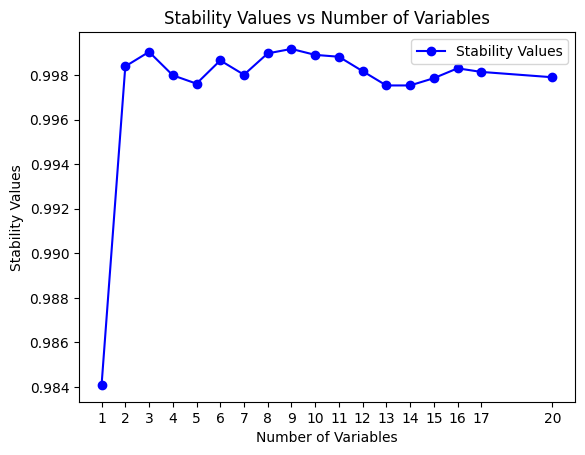

In [17]:
df_plot = result_stability.copy()


# Plotting the data
ax = df_plot.plot(x='number_variables', y='value_stab', marker='o', linestyle='-', color='b', label='Stability Values')

# Adding labels and title
plt.xlabel('Number of Variables')
plt.ylabel('Stability Values')
plt.title('Stability Values vs Number of Variables')

# Set x-axis ticks to match 'number_variables'
ax.set_xticks(df_plot['number_variables'])

# Display the plot
plt.show()

In [18]:
a

NameError: name 'a' is not defined

In [ ]:
import pandas as pd

# Initialize an empty DataFrame for stab_df
stab_df = pd.DataFrame(columns=['date_week', 'number_iteration', 'number_variables', 'value_stab', 'value_inst', 'Precision', 'Recall', 'F1_Score'])

weeks = get_last_weeks_mondays(df)
    
X_test, X_train = separate_datasets(df, weeks[0])

X_test = fake_data_label(X_train, X_test, feature_columns, categorical_features, numerical_features, model_type=model_type)

start_stab_df, start_result_df = get_stability_model(X_train, X_test, feature_columns, categorical_features, numerical_features, max_iterations=25, model_type=model_type)
# Need to choose start_result_df and create a vector to use it in the next iteration to calculate stability
# Take care about which dataset im using to train first the model. 


for week in weeks:
    
    X_test, X_train = separate_datasets(df, week)

    X_test = fake_data_label(X_train, X_test, feature_columns, categorical_features, numerical_features, model_type=model_type)

    # I need some code which follow the rules of the variables as before
    temp_stab_df, temp_result_df = get_stability_model(X_train, X_test, feature_columns, categorical_features, numerical_features, max_iterations=25, model_type=model_type)
    
    # Add 'date_week' column to temp_stab_df
    temp_stab_df['date_week'] = week
    
    stab_df = pd.concat([stab_df, temp_stab_df], ignore_index=True)


stab_df['number_iteration'] = stab_df['number_iteration'].astype(int)
stab_df['number_variables'] = stab_df['number_variables'].astype(int)
stab_df['value_stab'] = stab_df['value_stab'].astype(float)

In [ ]:
import matplotlib.pyplot as plt

# Get unique dates
unique_dates = stab_df['date_week'].unique()

# Plotting the data for each unique date
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

for date in unique_dates:
    df_plot = stab_df[stab_df['date_week'] == date].copy()
    
    # Plotting the data
    plt.plot(df_plot['number_variables'], df_plot['value_stab'], marker='o', linestyle='-', label=f'Stability Values - {date}')

# Adding labels and title
plt.xlabel('Number of Variables')
plt.ylabel('Stability Values')
plt.title('Stability Values vs Number of Variables')

# Display a legend to distinguish lines for each date
plt.legend()

# Show the plot
plt.show()

In [ ]:
df_plot = stab_df[stab_df.date_week == weeks[0]].copy()


# Plotting the data
ax = df_plot.plot(x='number_variables', y='value_stab', marker='o', linestyle='-', color='b', label='Stability Values')

# Adding labels and title
plt.xlabel('Number of Variables')
plt.ylabel('Stability Values')
plt.title('Stability Values vs Number of Variables')

# Set x-axis ticks to match 'number_variables'
ax.set_xticks(df_plot['number_variables'])

# Display the plot
plt.show()

In [ ]:
# Assuming df is your DataFrame
df = stab_df.copy()

# Convert 'number_variables' to integers
df['number_variables'] = df['number_variables'].astype(int)

# Plotting the first y-axis
fig, ax1 = plt.subplots()

ax1.set_xlabel('Number of Variables')
ax1.set_ylabel('Stability Values', color='b')
ax1.plot(df['number_variables'], df['value_stab'], marker='o', linestyle='-', color='b', label='Stability Values')
ax1.tick_params(axis='y', labelcolor='b')

# Creating the second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Recall & Precision', color='g')

# Adding the new variable to the second y-axis
ax2.plot(df['number_variables'], df['Recall'], marker='s', linestyle='--', color='g', label='Recall')
ax2.tick_params(axis='y', labelcolor='r')

# Adding the new variable to the second y-axis
ax2.plot(df['number_variables'], df['Precision'], marker='^', linestyle=':', color='g', label='Precision')
ax2.tick_params(axis='y', labelcolor='g')

# Set x-axis ticks to be integers
ax1.set_xticks(df['number_variables'])

# Adding a legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Stability Values and Recall vs Number of Variables')

# Display the plot
plt.show()